# Movie Recommendation System

In [1]:
from collections import Counter
from itertools import combinations
import re

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pk
from ast import literal_eval

from jupyterthemes import jtplot
jtplot.style(figsize=(15, 9))

## Data Cleaning

In [2]:
cast_df = pd.read_csv('../data/popular_10000_movies/cast_dataset.csv', index_col='id')
crew_df = pd.read_csv('../data/popular_10000_movies/crew_dataset.csv', index_col='id')
keywords_df = pd.read_csv('../data/popular_10000_movies/keywords_dataframe.csv', index_col='id')
mov_df = pd.read_csv('../data/popular_10000_movies/movies_dataset.csv', index_col='id')

In [3]:
keywords_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
movies_df = mov_df.merge(cast_df, on='id').merge(crew_df, on ='id').merge(keywords_df, on ='id')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

In [5]:
movies_df.head()

,genre_ids,original_language,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,,
385687,"[28, 80, 53]",en,Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 1302, 'name': 'Susie Figgis', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",en,Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'cast_id': 74568, 'name': 'Chris Hemsworth',...","[{'crew_id': 950, 'name': 'Pietro Scalia', 'de...","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
603692,"[28, 53, 80]",en,"With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 242, 'name': 'new york city'}, {'id': ..."
569094,"[28, 12, 16, 878]",en,"After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
502356,"[16, 10751, 12, 14, 35]",en,"While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 70851, 'name': 'Jack Black', 'dep...","[{'id': 282, 'name': 'video game'}, {'id': 690..."


In [6]:
movies_df.shape

(10652, 12)

In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10652 entries, 385687 to 465109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          10652 non-null  object        
 1   original_language  10652 non-null  object        
 2   overview           10649 non-null  object        
 3   popularity         10652 non-null  float64       
 4   release_date       10636 non-null  datetime64[ns]
 5   title              10652 non-null  object        
 6   vote_average       10652 non-null  float64       
 7   vote_count         10652 non-null  int64         
 8   genres             10634 non-null  object        
 9   cast               10652 non-null  object        
 10  crew               10652 non-null  object        
 11  keywords           10652 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 749.0+ KB


In [8]:
movies_df['original_language'].value_counts()

en    10652
Name: original_language, dtype: int64

In [9]:
movies_df.drop('original_language', axis=1, inplace=True)

In [10]:
movies_df.isnull().sum()

genre_ids        0
overview         3
popularity       0
release_date    16
title            0
vote_average     0
vote_count       0
genres          18
cast             0
crew             0
keywords         0
dtype: int64

In [11]:
movies_df.drop(movies_df[movies_df['keywords']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['cast']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['crew']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_average']==0].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_count']<100].index, axis=0, inplace=True)
movies_df.dropna(axis=0, inplace=True)

In [12]:
movies_df.isnull().sum()

genre_ids       0
overview        0
popularity      0
release_date    0
title           0
vote_average    0
vote_count      0
genres          0
cast            0
crew            0
keywords        0
dtype: int64

In [13]:
movies_df[movies_df.duplicated()].shape

(515, 11)

In [14]:
movies_df.drop_duplicates(inplace=True)

In [15]:
movies_df[movies_df.duplicated()].shape

(0, 11)

## EDA

In [16]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=False).head(10)

,popularity,vote_average,vote_count
genres,,,
"Fantasy, Drama, Crime",69.123,8.5,15537.0
"Drama, Thriller, Comedy",73.566,8.4,26647.0
"TV Movie, Animation, Science Fiction, Action, Adventure, Comedy, Drama, Fantasy, Music",24.249,8.3,754.0
"Family, Animation, Drama",97.326,8.3,16649.0
"Animation, Family, Fantasy, Adventure, Comedy",502.086,8.3,5832.0
"Horror, Music",12.705,8.2,581.0
"Family, Animation, Music",15.704,8.2,143.0
"Family, Animation, Fantasy, Music, Comedy, Adventure",106.932,8.2,17338.0
"Animation, Fantasy, Drama, Music",89.246,8.2,2327.0


In [17]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=True).head(10)

,popularity,vote_average,vote_count
genres,,,
"Action, Adventure, Fantasy, Science Fiction, Thriller",33.077,2.9,1867.0
"Science Fiction, Horror, Action, Thriller",13.295,2.9,117.0
"Fantasy, Science Fiction, Family, TV Movie",15.379,3.3,408.0
"Horror, Action, Comedy, Science Fiction, Adventure",11.146,3.9,1436.0
"Science Fiction, Comedy, Family",11.359,4.0,321.0
"Adventure, Thriller, Horror",18.743,4.1,885.0
"Crime, Fantasy, Horror, Thriller",16.582,4.2,3696.0
"Horror, Comedy, Mystery, Thriller",16.356,4.3,1168.0
"Mystery, Adventure, Comedy, Crime",15.003,4.3,741.0


In [18]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,cast,crew,keywords
genres,,,,,,,,,,
Drama,405,405,405,405,405,405,405,405,405,405
Comedy,346,346,346,346,346,346,346,346,346,346
"Comedy, Romance",222,222,222,222,222,222,222,222,222,222
"Drama, Romance",214,214,214,214,214,214,214,214,214,214
"Horror, Thriller",170,170,170,170,170,170,170,170,170,170
"Comedy, Drama",169,169,169,169,169,169,169,169,169,169
Horror,140,140,140,140,140,140,140,140,140,140
"Comedy, Drama, Romance",137,137,137,137,137,137,137,137,137,137
"Drama, History",100,100,100,100,100,100,100,100,100,100


In [19]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).tail(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,cast,crew,keywords
genres,,,,,,,,,,
"Adventure, Drama, Science Fiction, Fantasy",1,1,1,1,1,1,1,1,1,1
"Adventure, Family, Action, Fantasy",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Western",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, TV Movie",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Romance",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Horror",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, History",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Fantasy",1,1,1,1,1,1,1,1,1,1
"Adventure, Drama, Thriller, History",1,1,1,1,1,1,1,1,1,1


In [24]:
movies_df.sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
238,"[18, 80]","Spanning the years 1945 to 1955, a chronicle o...",120.966,1972-03-14,The Godfather,8.7,18141,"Drama, Crime","[{'cast_id': 3084, 'name': 'Marlon Brando', 'c...","[{'crew_id': 154, 'name': 'Walter Murch', 'dep...","[{'id': 131, 'name': 'italy'}, {'id': 697, 'na..."
278,"[18, 80]",Framed in the 1940s for the double murder of h...,107.982,1994-09-23,The Shawshank Redemption,8.7,24021,"Drama, Crime","[{'cast_id': 504, 'name': 'Tim Robbins', 'char...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 378, 'name': 'prison'}, {'id': 417, 'n..."
373558,"[10402, 99]","Filmed in front of 76,000 fans at the ANZ Stad...",15.562,2015-12-20,Taylor Swift: The 1989 World Tour - Live,8.7,119,"Music, Documentary","[{'cast_id': 212208, 'name': 'Taylor Swift', '...","[{'crew_id': 71329, 'name': 'Jonas Åkerlund', ...","[{'id': 1740, 'name': 'pop culture'}, {'id': 2..."
240,"[18, 80]",In the continuing saga of the Corleone crime f...,68.191,1974-12-20,The Godfather Part II,8.6,10949,"Drama, Crime","[{'cast_id': 1158, 'name': 'Al Pacino', 'chara...","[{'crew_id': 154, 'name': 'Walter Murch', 'dep...","[{'id': 131, 'name': 'italy'}, {'id': 700, 'na..."
424,"[18, 36, 10752]",The true story of how businessman Oskar Schind...,60.506,1993-12-15,Schindler's List,8.6,14198,"Drama, History, War","[{'cast_id': 3896, 'name': 'Liam Neeson', 'cha...","[{'crew_id': 491, 'name': 'John Williams', 'de...","[{'id': 818, 'name': 'based on novel or book'}..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
155,"[18, 28, 80, 53]",Batman raises the stakes in his war on crime. ...,90.659,2008-07-14,The Dark Knight,8.5,29936,"Drama, Action, Crime, Thriller","[{'cast_id': 3894, 'name': 'Christian Bale', '...","[{'crew_id': 1113, 'name': 'Lucinda Syson', 'd...","[{'id': 853, 'name': 'crime fighter'}, {'id': ..."
680,"[53, 80]","A burger-loving hit man, his philosophical par...",76.675,1994-09-10,Pulp Fiction,8.5,25346,"Thriller, Crime","[{'cast_id': 8891, 'name': 'John Travolta', 'c...","[{'crew_id': 138, 'name': 'Quentin Tarantino',...","[{'id': 2231, 'name': 'drug dealer'}, {'id': 2..."
770156,"[10751, 18]",Second chances start when a hardened criminal ...,21.416,2020-10-19,Lucy Shimmers And The Prince Of Peace,8.5,131,"Family, Drama","[{'cast_id': 2643437, 'name': 'Scarlett Diamon...","[{'crew_id': 222497, 'name': 'Rob Diamond', 'd...","[{'id': 3071, 'name': 'prince'}, {'id': 6057, ..."


In [23]:
movies_df.sort_values(['vote_average'], ascending=True).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
19157,[35],A struggling young comedian takes a menial job...,11.868,1989-05-11,Going Overboard,2.3,112,Comedy,"[{'cast_id': 19292, 'name': 'Adam Sandler', 'c...","[{'crew_id': 19292, 'name': 'Adam Sandler', 'd...","[{'id': 407, 'name': 'dictator'}, {'id': 2398,..."
10838,"[27, 878]","In the year 3000, the deep space salvage ship ...",11.360,2004-08-09,Dracula 3000,2.7,114,"Horror, Science Fiction","[{'cast_id': 27763, 'name': 'Casper Van Dien',...","[{'crew_id': 15303, 'name': 'Frank Hübner', 'd...","[{'id': 1826, 'name': 'space marine'}, {'id': ..."
11525,"[878, 27, 28, 53]",Jobe is resuscitated by Jonathan Walker. He wa...,13.295,1996-01-12,Lawnmower Man 2: Beyond Cyberspace,2.9,117,"Science Fiction, Horror, Action, Thriller","[{'cast_id': 29459, 'name': 'Patrick Bergin', ...","[{'crew_id': 582, 'name': 'Sheri Galloway', 'd...","[{'id': 1576, 'name': 'technology'}, {'id': 21..."
14164,"[28, 12, 14, 878, 53]","On his 18th birthday, Goku receives a mystical...",33.077,2009-03-12,Dragonball Evolution,2.9,1867,"Action, Adventure, Fantasy, Science Fiction, T...","[{'cast_id': 503, 'name': 'Justin Chatwin', 'c...","[{'crew_id': 561, 'name': 'John Papsidera', 'd...","[{'id': 3436, 'name': 'karate'}, {'id': 9715, ..."
11059,"[27, 28, 53]","Set on an island off the coast, a techno rave ...",11.457,2003-04-11,House of the Dead,3.2,339,"Horror, Action, Thriller","[{'cast_id': 51937, 'name': 'Jonathan Cherry',...","[{'crew_id': 22455, 'name': 'Dan Sales', 'depa...","[{'id': 2041, 'name': 'island'}, {'id': 3221, ..."
5491,"[28, 12, 35, 878]","In the year 3000, man is no match for the Psyc...",12.444,2000-05-12,Battlefield Earth,3.2,725,"Action, Adventure, Comedy, Science Fiction","[{'cast_id': 8891, 'name': 'John Travolta', 'c...","[{'crew_id': 1263, 'name': 'Lynn Stalmaster', ...","[{'id': 818, 'name': 'based on novel or book'}..."
135812,[27],When Englishman Jonathan Harker visits the exo...,12.126,2012-11-09,Dracula 3D,3.3,192,Horror,"[{'cast_id': 3491, 'name': 'Thomas Kretschmann...","[{'crew_id': 1544, 'name': 'Bram Stoker', 'dep...","[{'id': 3133, 'name': 'vampire'}, {'id': 15032..."
13805,"[35, 878]","The filmmaking team behind the hits ""Scary Mov...",17.125,2008-08-29,Disaster Movie,3.3,930,"Comedy, Science Fiction","[{'cast_id': 34202, 'name': 'Matt Lanter', 'ch...","[{'crew_id': 3687, 'name': 'Harry Cohen', 'dep...","[{'id': 5096, 'name': 'natural disaster'}, {'i..."
12142,"[28, 14, 27]",Edward Carnby is a private investigator specia...,13.641,2005-01-28,Alone in the Dark,3.3,527,"Action, Fantasy, Horror","[{'cast_id': 2224, 'name': 'Christian Slater',...","[{'crew_id': 21251, 'name': 'Robert Lee', 'dep...","[{'id': 703, 'name': 'detective'}, {'id': 1299..."


In [22]:
movies_df.sort_values(['popularity'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
385687,"[28, 80, 53]",Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 1302, 'name': 'Susie Figgis', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'cast_id': 74568, 'name': 'Chris Hemsworth',...","[{'crew_id': 950, 'name': 'Pietro Scalia', 'de...","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
603692,"[28, 53, 80]","With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 242, 'name': 'new york city'}, {'id': ..."
502356,"[16, 10751, 12, 14, 35]","While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 70851, 'name': 'Jack Black', 'dep...","[{'id': 282, 'name': 'video game'}, {'id': 690..."
667538,"[28, 12, 878]",When a new threat capable of destroying the en...,1423.735,2023-06-06,Transformers: Rise of the Beasts,7.1,469,"Action, Adventure, Science Fiction","[{'cast_id': 1560244, 'name': 'Anthony Ramos',...","[{'crew_id': 488, 'name': 'Steven Spielberg', ...","[{'id': 5967, 'name': 'peru'}, {'id': 9951, 'n..."
976573,"[16, 35, 10751, 14, 10749]","In a city where fire, water, land and air resi...",1224.270,2023-06-14,Elemental,7.4,200,"Animation, Comedy, Family, Fantasy, Romance","[{'cast_id': 1087262, 'name': 'Leah Lewis', 'c...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 657, 'name': 'fire'}, {'id': 10159, 'n..."
298618,"[878, 28, 12]",When his attempt to save his family inadverten...,965.786,2023-06-13,The Flash,6.7,639,"Science Fiction, Action, Adventure","[{'cast_id': 132157, 'name': 'Ezra Miller', 'c...","[{'crew_id': 2293, 'name': 'Frank Miller', 'de...","[{'id': 1308, 'name': 'secret identity'}, {'id..."
447365,"[28, 878, 12]","Peter Quill, still reeling from the loss of Ga...",960.044,2023-05-03,Guardians of the Galaxy Vol. 3,8.0,2111,"Action, Science Fiction, Adventure","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 960, 'name': 'John Murphy', 'depa...","[{'id': 1701, 'name': 'hero'}, {'id': 9663, 'n..."


### Visualization

Text(0, 0.5, 'Popular Genres')

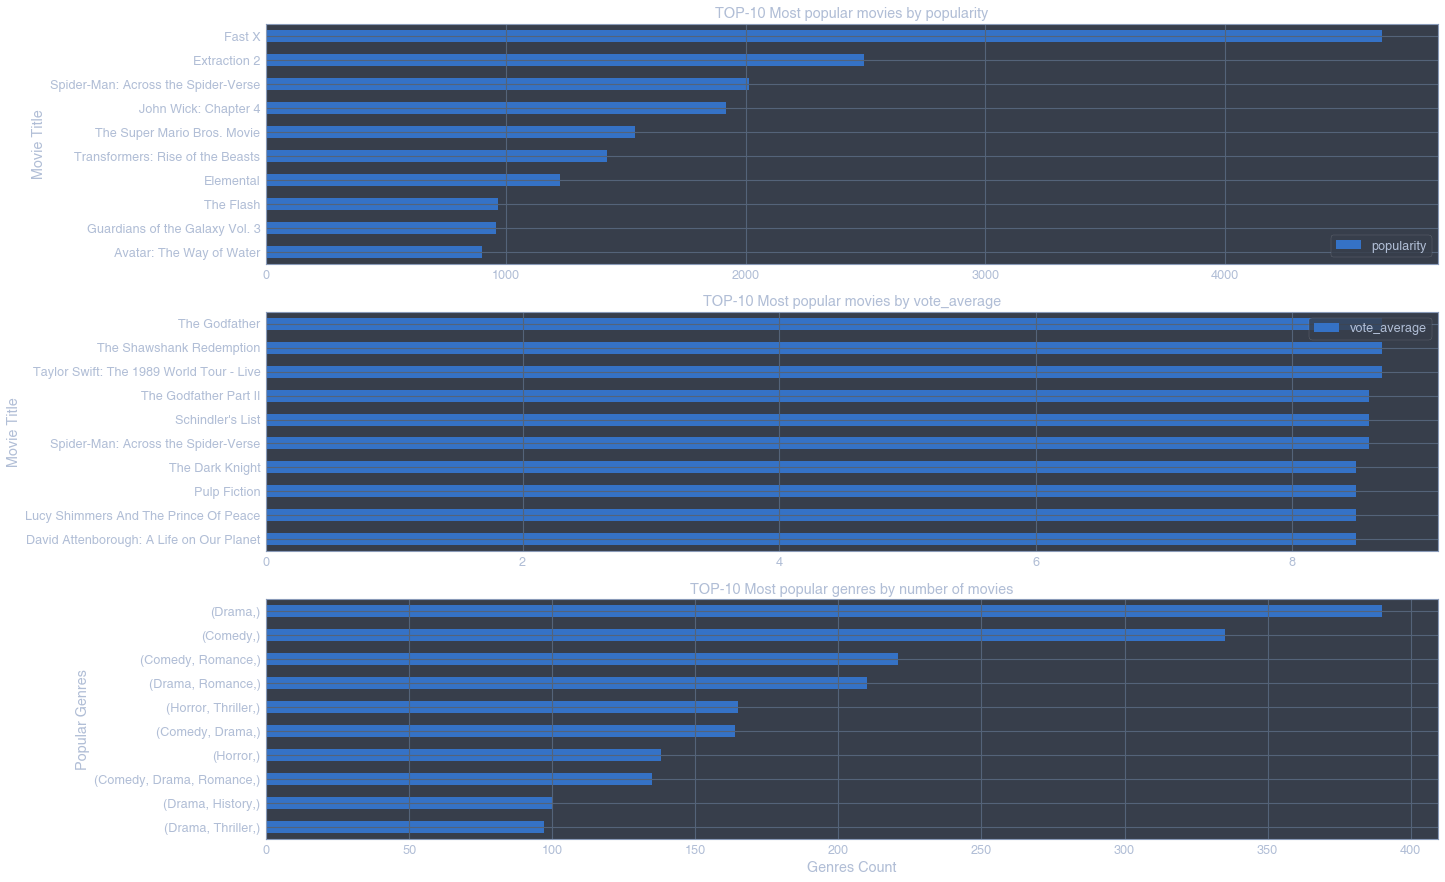

In [30]:
movies_by_popularity = movies_df.sort_values(['popularity'], ascending=False)\
                                .head(10)[['title', 'popularity']]\
                                .reset_index(drop=True)
movies_by_popularity.set_index('title', inplace=True)

movies_by_vote_average = movies_df.sort_values(['vote_average'], ascending=False)\
                                  .head(10)[['title', 'vote_average']]\
                                  .reset_index(drop=True)
movies_by_vote_average.set_index('title', inplace=True)

genres_by_date = movies_df.groupby('release_date')['genres']\
                          .value_counts()\
                          .to_frame()\
                          .rename(columns={'genres': 'genres_count'})\
                          .reset_index()

fig, ax = plt.subplots(3, 1, figsize=(21, 15))

movies_by_popularity.plot(kind='barh', ax=ax[0]).invert_yaxis()
ax[0].set_title('TOP-10 Most popular movies by popularity')
ax[0].set_ylabel('Movie Title')

movies_by_vote_average.plot(kind='barh', ax=ax[1]).invert_yaxis()
ax[1].set_title('TOP-10 Most popular movies by vote_average')
ax[1].set_ylabel('Movie Title')

genres_by_date.value_counts(['genres']).head(10).plot(kind='barh', x='genres', y='genres_count', ax=ax[2]).invert_yaxis()
ax[2].set_title('TOP-10 Most popular genres by number of movies')
ax[2].set_xlabel('Genres Count')
ax[2].set_ylabel('Popular Genres')

Text(0, 0.5, 'Vote Count')

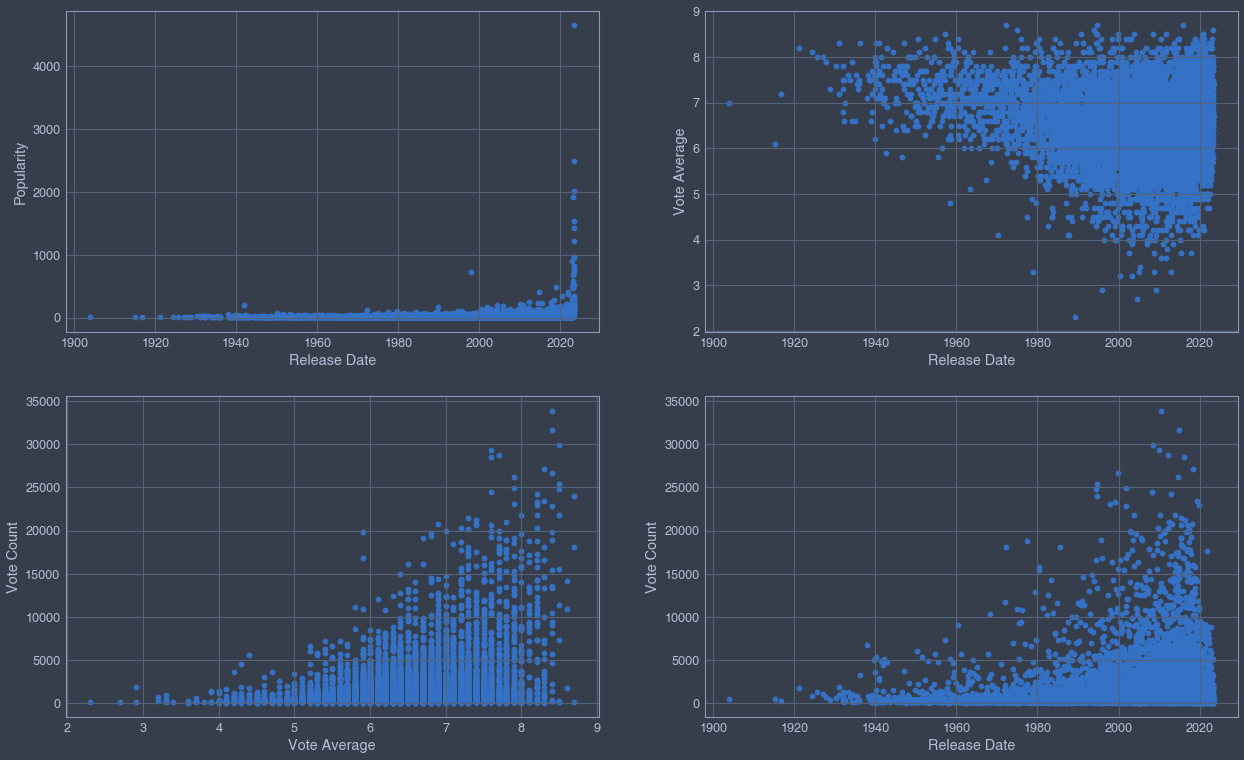

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(21, 13))

axs[0, 0].scatter(movies_df['release_date'], movies_df['popularity'])
axs[0, 0].set_xlabel('Release Date')
axs[0, 0].set_ylabel('Popularity')

axs[0, 1].scatter(movies_df['release_date'], movies_df['vote_average'])
axs[0, 1].set_xlabel('Release Date')
axs[0, 1].set_ylabel('Vote Average')

axs[1, 0].scatter(movies_df['vote_average'], movies_df['vote_count'])
axs[1, 0].set_xlabel('Vote Average')
axs[1, 0].set_ylabel('Vote Count')

axs[1, 1].scatter(movies_df['release_date'], movies_df['vote_count'])
axs[1, 1].set_xlabel('Release Date')
axs[1, 1].set_ylabel('Vote Count')

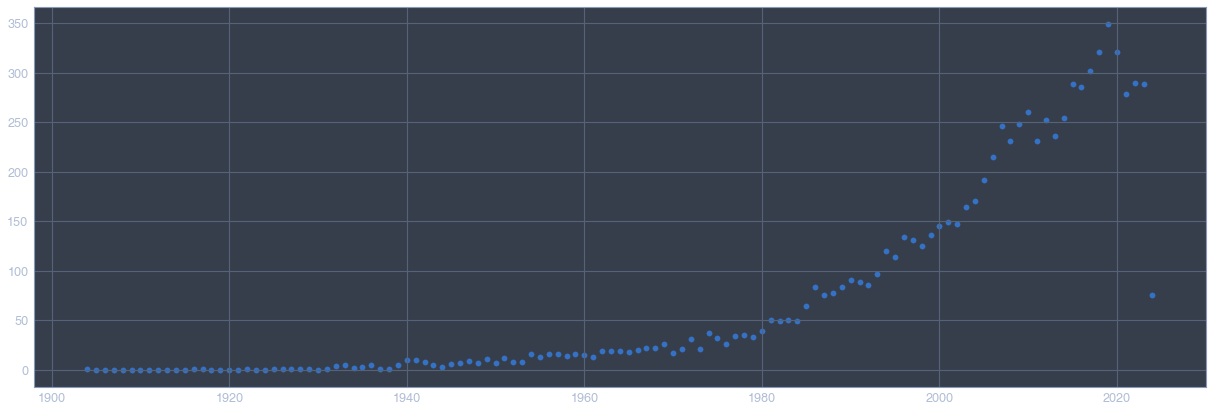

In [24]:
release_date_index = movies_df.copy()
release_date_index.reset_index(inplace=True)
release_date_index.set_index(['release_date'], inplace=True)

movies_by_years = release_date_index.resample('1Y').count()['id']

fig, ax = plt.subplots(figsize=(21, 7))
ax.scatter(movies_by_years.index, movies_by_years)

## Helpers

In [43]:
def flat_list(nest):
    return [egg for one_more_nest in nest for egg in one_more_nest]


def get_vectors(df: pd.DataFrame, unique_list: list, unique_genres: list)->pd.DataFrame:
    df_vectors = pd.DataFrame(0, index=unique_list, columns=unique_genres)
    df_vectors.head()
    
    for _id in df.index:
        row = df.loc[_id][0]
        genres_vector = OH_GENRES.loc[_id].to_list()
        for item in row:
            df_vectors.loc[item] += genres_vector
    
    return df_vectors


def get_sum_of_vectors(df: pd.DataFrame, df_vectors: pd.DataFrame, unique_list: list)->pd.DataFrame:
    df_vectors_sum = pd.DataFrame(index=df.index, columns=unique_list)
    
    def get_sum(row):
        _id = row.name
        _ids = df_vectors.loc[df.loc[_id][0]]
        
        return _ids.sum()

    df_vectors_sum = df.apply(get_sum, axis=1)
    
    return df_vectors_sum


## Genres

In [16]:
genres_list = list(movies_df['genres'].unique())

for i, g in enumerate(genres_list):
    genres_list[i] = g.split(', ')
    
genres_list[:20]

[['Action', 'Crime', 'Thriller'],
 ['Action', 'Thriller'],
 ['Action', 'Thriller', 'Crime'],
 ['Action', 'Adventure', 'Animation', 'Science Fiction'],
 ['Animation', 'Family', 'Adventure', 'Fantasy', 'Comedy'],
 ['Action', 'Adventure', 'Science Fiction'],
 ['Animation', 'Comedy', 'Family', 'Fantasy', 'Romance'],
 ['Mystery', 'Thriller', 'Science Fiction'],
 ['Science Fiction', 'Action', 'Adventure'],
 ['Action', 'Science Fiction', 'Adventure'],
 ['Science Fiction', 'Adventure', 'Action'],
 ['Adventure', 'Family', 'Fantasy', 'Romance'],
 ['Thriller', 'Horror'],
 ['Horror', 'Thriller'],
 ['War', 'Action', 'Thriller'],
 ['Drama', 'Romance'],
 ['Comedy', 'Action', 'Fantasy'],
 ['Comedy', 'Drama'],
 ['Animation', 'Family', 'Fantasy', 'Adventure', 'Comedy'],
 ['Drama', 'Action']]

In [19]:
un_genres_list = flat_list(genres_list)
un_genres_list = list(set(un_genres_list))

un_genres_list

['Western',
 'Family',
 'Thriller',
 'War',
 'Horror',
 'TV Movie',
 'Action',
 'Comedy',
 'Romance',
 'History',
 'Fantasy',
 'Mystery',
 'Crime',
 'Music',
 'Documentary',
 'Drama',
 'Animation',
 'Science Fiction',
 'Adventure']

In [20]:
genres_counter = {}
l = []
for g in un_genres_list:
    for gs in genres_list:
        if g in gs:
            l.extend(gs)
    genres_counter[g] = dict(Counter(l))
    l = []

genres_counter['Animation']

{'Action': 118,
 'Adventure': 202,
 'Animation': 378,
 'Science Fiction': 90,
 'Family': 280,
 'Fantasy': 151,
 'Comedy': 200,
 'Romance': 26,
 'Music': 32,
 'Drama': 31,
 'TV Movie': 30,
 'Crime': 13,
 'Thriller': 10,
 'Horror': 15,
 'Mystery': 38,
 'Western': 7,
 'War': 5,
 'History': 3}

In [21]:
genres_df = pd.DataFrame(columns=un_genres_list, index=un_genres_list)

for genre in un_genres_list:
    g = {}
    for u_genre in un_genres_list:
        if u_genre in genres_counter[genre].keys():
            g[u_genre] =  genres_counter[genre][u_genre]
        else:
            g[u_genre] = 0
    genres_df.loc[genre] = g

genres_df

,Western,Family,Thriller,War,Horror,TV Movie,Action,Comedy,Romance,History,Fantasy,Mystery,Crime,Music,Documentary,Drama,Animation,Science Fiction,Adventure
Western,96,8,18,2,6,2,35,23,17,4,5,5,12,1,0,48,7,3,40
Family,8,556,7,3,12,71,129,340,75,7,242,39,15,64,1,106,280,100,305
Thriller,18,7,586,36,152,14,251,92,66,37,67,186,192,4,1,272,10,145,105
War,2,3,36,128,5,4,59,14,24,50,3,5,2,2,0,91,5,8,36
Horror,6,12,152,5,325,12,105,73,17,3,94,81,36,7,1,79,15,96,48
TV Movie,2,71,14,4,12,142,24,71,20,6,37,9,9,20,1,45,30,27,35
Action,35,129,251,59,105,24,717,203,50,47,142,70,152,8,3,196,118,216,327
Comedy,23,340,92,14,73,71,203,754,142,10,230,79,112,86,5,174,200,122,291
Romance,17,75,66,24,17,20,50,142,341,20,79,34,37,42,0,185,26,33,79
History,4,7,37,50,3,6,47,10,20,142,1,8,19,7,3,117,3,0,33


Text(0.5, 1.0, '')

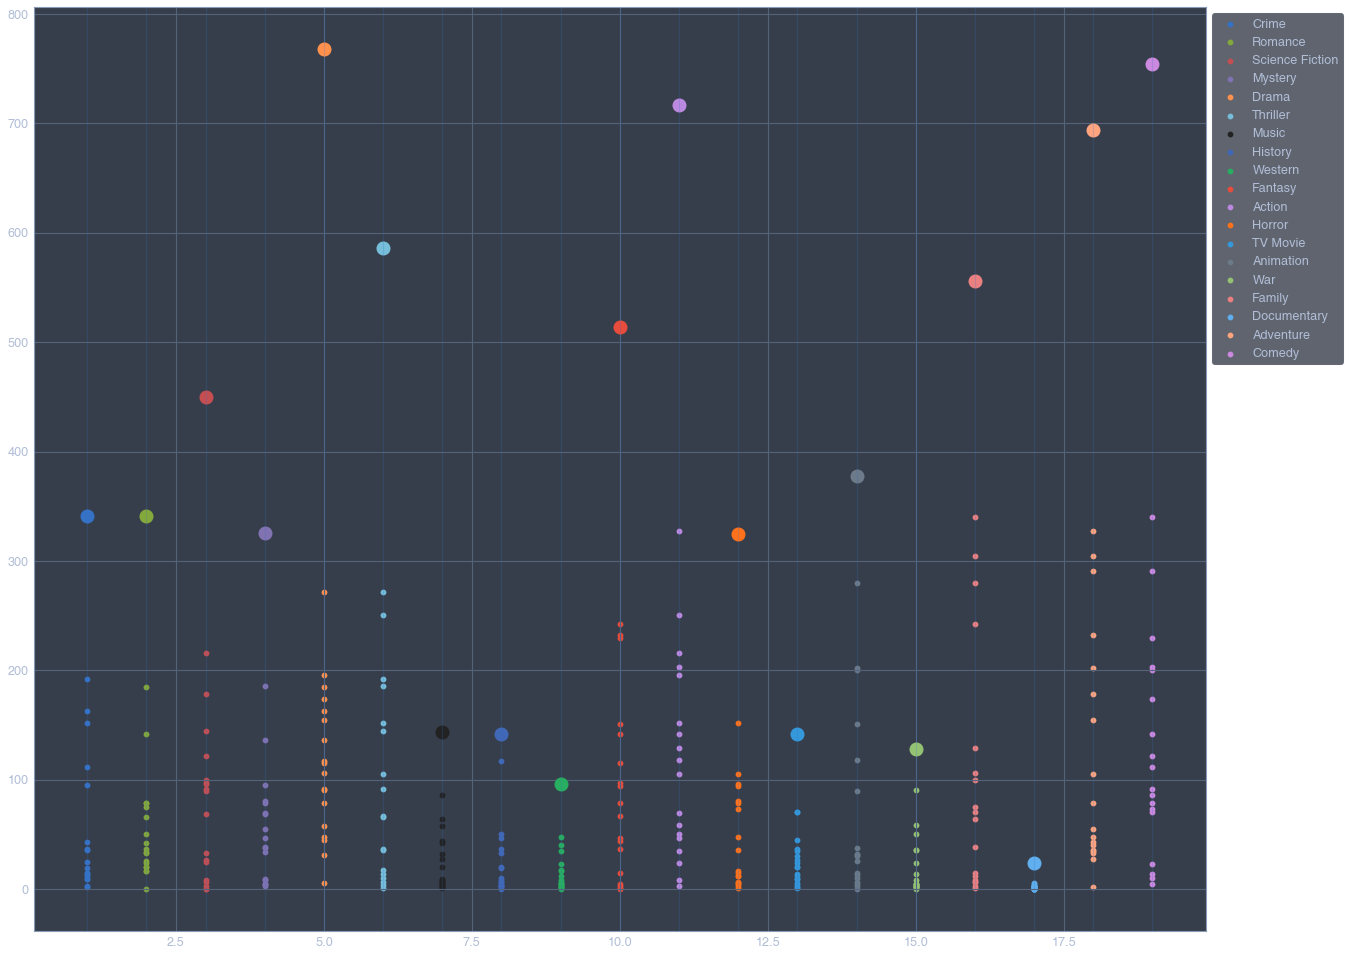

In [34]:
y = np.full(genres_df['Fantasy'].shape[0], 1)
fig, axs = plt.subplots(1, 1, figsize=(21, 17))

for n, i in enumerate(genres_df.columns):        
    axs.scatter(np.full(genres_df['Fantasy'].shape[0], n+1), genres_df[i], label=i)
    axs.plot(n+1, genres_df[i][i], 'o', markersize=14)
    axs.axvline(n+1, alpha=0.2)

axs.legend(bbox_to_anchor=(1.0, 1.0))
axs.set_title('')

In [22]:
genres_cs = pd.DataFrame(data=cosine_similarity(genres_df), index=genres_df.index, columns=genres_df.columns)

Text(0.5, 1.0, 'Correlation')

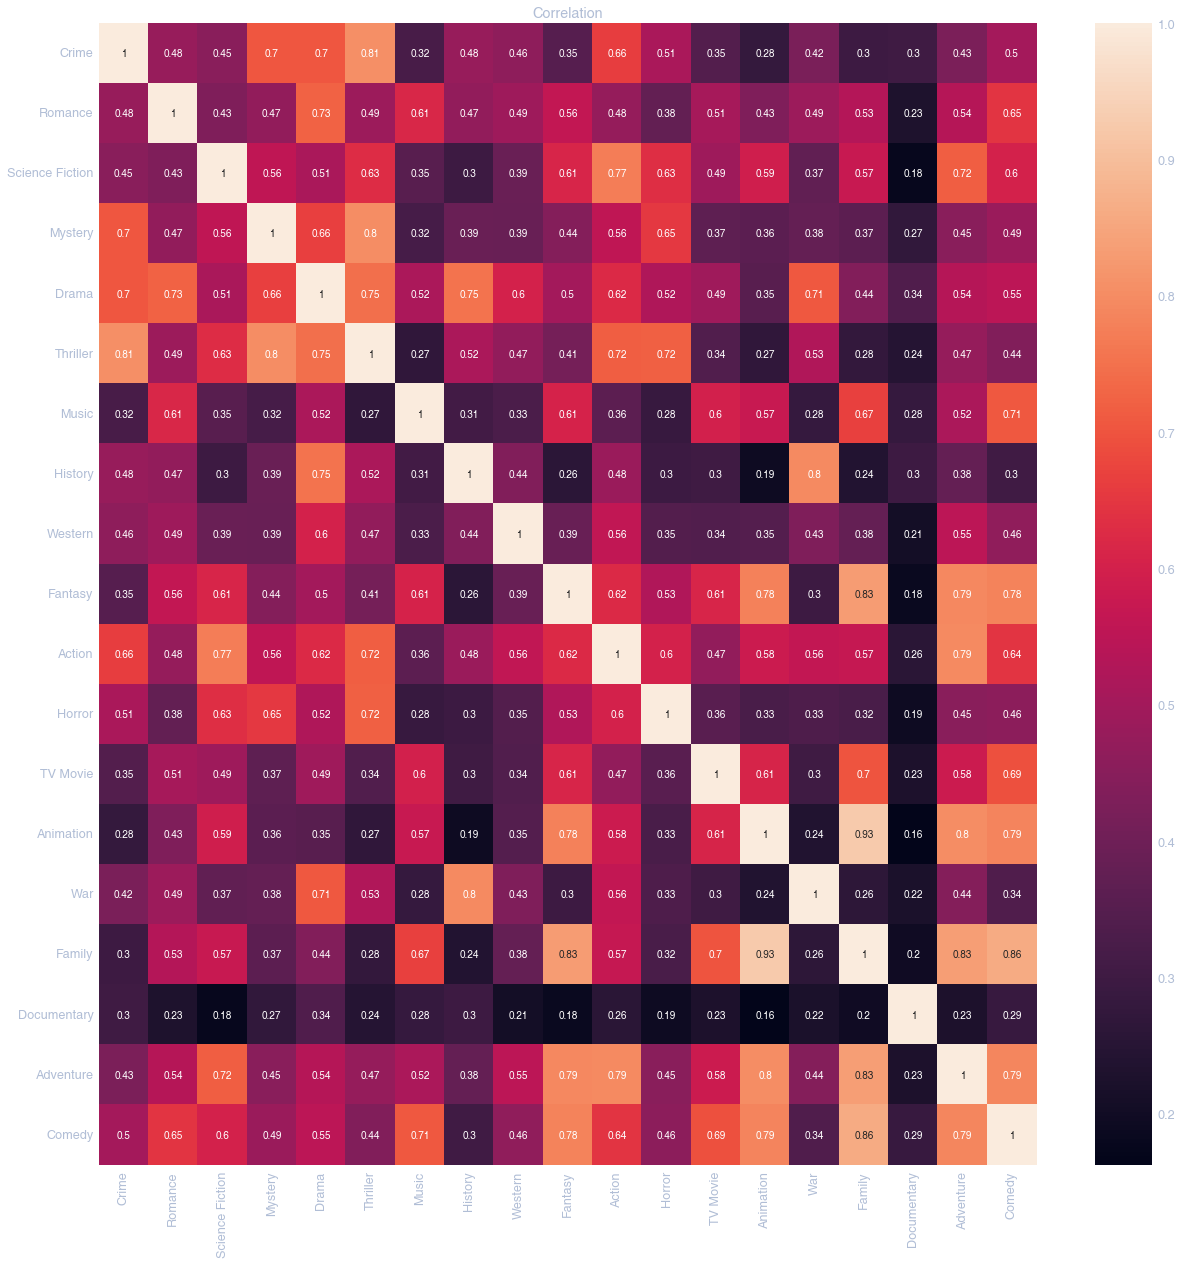

In [39]:
plt.figure(figsize=(21, 21))
sns.heatmap(genres_cs, annot=True)
plt.title('Correlation')

### One-Hot Genres

In [22]:
OH_GENRES = pd.DataFrame(index=movies_df.index, columns=un_genres_list)
OH_GENRES.head()

,Western,Family,Thriller,War,Horror,TV Movie,Action,Comedy,Romance,History,Fantasy,Mystery,Crime,Music,Documentary,Drama,Animation,Science Fiction,Adventure
id,,,,,,,,,,,,,,,,,,,
385687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
genres = movies_df['genres'].to_frame()

In [24]:
for i in range(genres.shape[0]):
    df = np.full(len(un_genres_list), 0)
    
    for j in str(genres['genres'].iloc[i]).split(', '):
        df[un_genres_list.index(j)] = 1

    OH_GENRES.iloc[i] = df
        
OH_GENRES.head()

,Western,Family,Thriller,War,Horror,TV Movie,Action,Comedy,Romance,History,Fantasy,Mystery,Crime,Music,Documentary,Drama,Animation,Science Fiction,Adventure
id,,,,,,,,,,,,,,,,,,,
385687,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
697843,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
603692,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
569094,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1
502356,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1


## Prepare Keywords

### Clean keywords

In [25]:
keywords_list_of_the_dicts = []
for l in movies_df['keywords'].to_list():
    keywords_list_of_the_dicts.append(literal_eval(l))

keywords_list_of_the_dicts[:5]

[[{'id': 9663, 'name': 'sequel'},
  {'id': 9748, 'name': 'revenge'},
  {'id': 10039, 'name': 'racing'},
  {'id': 18035, 'name': 'family'},
  {'id': 286354, 'name': 'cars'}],
 [{'id': 3070, 'name': 'mercenary'},
  {'id': 9663, 'name': 'sequel'},
  {'id': 11107, 'name': 'rescue mission'},
  {'id': 11440, 'name': 'long take'},
  {'id': 18712, 'name': 'based on graphic novel'}],
 [{'id': 242, 'name': 'new york city'},
  {'id': 779, 'name': 'martial arts'},
  {'id': 2708, 'name': 'hitman'},
  {'id': 9663, 'name': 'sequel'},
  {'id': 10291, 'name': 'organized crime'},
  {'id': 10642, 'name': 'osaka, japan'},
  {'id': 179430, 'name': 'aftercreditsstinger'},
  {'id': 181644, 'name': 'hunted'},
  {'id': 206041, 'name': 'professional assassin'},
  {'id': 207268, 'name': 'neo-noir'},
  {'id': 312965, 'name': 'berlin'}],
 [{'id': 2858, 'name': 'sacrifice'},
  {'id': 3289, 'name': 'villain'},
  {'id': 5451, 'name': 'comic book'},
  {'id': 9663, 'name': 'sequel'},
  {'id': 9715, 'name': 'superhero'}

In [26]:
trash_keywords = ['aftercreditsstinger', 'duringcreditsstinger']

In [27]:
keywords_list_of_the_lists = [[k_d['name'] for k_d in k_l if k_d['name'] not in trash_keywords]
                              for k_l in keywords_list_of_the_dicts]

keywords_list_of_the_lists[:5]

[['sequel', 'revenge', 'racing', 'family', 'cars'],
 ['mercenary',
  'sequel',
  'rescue mission',
  'long take',
  'based on graphic novel'],
 ['new york city',
  'martial arts',
  'hitman',
  'sequel',
  'organized crime',
  'osaka, japan',
  'hunted',
  'professional assassin',
  'neo-noir',
  'berlin'],
 ['sacrifice',
  'villain',
  'comic book',
  'sequel',
  'superhero',
  'based on comic',
  'alternate dimension',
  'alternate version',
  'super power',
  'brooklyn, new york city',
  'superhero team',
  'spider bite',
  'super villain',
  'cliffhanger',
  'teen superhero',
  'alternate universe',
  'female superhero',
  'cartoon spider'],
 ['video game',
  'gorilla',
  'plumber',
  'magic mushroom',
  'anthropomorphism',
  'based on video game',
  'toad',
  'damsel in distress',
  'piano',
  'white gloves',
  'brother brother relationship',
  'evil king']]

### Find empty lists in keywords

In [28]:
[] in keywords_list_of_the_lists

True

In [29]:
# [keywords_list_of_the_lists.remove(l) for l in keywords_list_of_the_lists if l == []] # remove empty lists

In [30]:
empty_indxs = [n for n, l in enumerate(keywords_list_of_the_lists) if l == []]
empty_indxs

[184, 476, 1094, 2022, 3655, 4071, 4485, 5432, 5535, 6655, 6885, 7481, 7504]

In [31]:
movies_df.iloc[empty_indxs]

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
752623,"[28, 12, 35]",Reclusive author Loretta Sage writes about exo...,84.431,2022-03-24,The Lost City,6.6,2823,"Action, Adventure, Comedy","[{'cast_id': 18277, 'name': 'Sandra Bullock', ...","[{'crew_id': 3989, 'name': 'Marlene Stewart', ...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
567189,"[12, 28, 53, 10752]",An elite Navy SEAL uncovers an international c...,55.306,2021-04-29,Tom Clancy's Without Remorse,7.0,2187,"Adventure, Action, Thriller, War","[{'cast_id': 135651, 'name': 'Michael B. Jorda...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
45610,"[28, 53, 80]","The true story of Sam Childers, a former drug-...",36.352,2011-09-23,Machine Gun Preacher,6.7,914,"Action, Thriller, Crime","[{'cast_id': 17276, 'name': 'Gerard Butler', '...","[{'crew_id': 1890, 'name': 'Philip Messina', '...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
76489,[35],While trying to save their childhood orphanage...,25.731,2012-04-13,The Three Stooges,5.8,498,Comedy,"[{'cast_id': 52601, 'name': 'Sean Hayes', 'cha...","[{'crew_id': 11079, 'name': 'Cindy Carr', 'dep...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
23172,"[28, 35, 10751]",Former CIA spy Bob Ho takes on his toughest as...,18.654,2010-01-15,The Spy Next Door,5.9,1158,"Action, Comedy, Family","[{'cast_id': 18897, 'name': 'Jackie Chan', 'ch...","[{'crew_id': 1060, 'name': 'Dean Cundey', 'dep...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
33909,"[18, 80]",As the global economy teeters on the brink of ...,17.574,2010-09-20,Wall Street: Money Never Sleeps,6.1,1362,"Drama, Crime","[{'cast_id': 3392, 'name': 'Michael Douglas', ...","[{'crew_id': 3687, 'name': 'Harry Cohen', 'dep...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
208134,[35],86-year-old Irving Zisman is on a journey acro...,16.949,2013-10-22,Jackass Presents: Bad Grandpa,6.1,1424,Comedy,"[{'cast_id': 9656, 'name': 'Johnny Knoxville',...","[{'crew_id': 5953, 'name': 'Spike Jonze', 'dep...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
88036,"[10402, 18]","Musical prodigy, Sparkle struggles to become a...",14.919,2012-08-17,Sparkle,6.3,104,"Music, Drama","[{'cast_id': 224842, 'name': 'Jordin Sparks', ...","[{'crew_id': 3117, 'name': 'Gary Frutkoff', 'd...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"
4959,"[28, 53, 18, 80]",An interpol agent and an attorney are determin...,14.766,2009-02-03,The International,6.2,1087,"Action, Thriller, Drama, Crime","[{'cast_id': 2296, 'name': 'Clive Owen', 'char...","[{'crew_id': 282, 'name': 'Charles Roven', 'de...","[{'id': 179431, 'name': 'duringcreditsstinger'}]"


In [32]:
len(keywords_list_of_the_lists), movies_df.shape[0]

(8401, 8401)

In [33]:
keywords = pd.DataFrame(index=movies_df.index,
                        columns=['keywords_list'],
                        data=np.array(keywords_list_of_the_lists, dtype=object))
keywords.head()

,keywords_list
id,
385687,"[sequel, revenge, racing, family, cars]"
697843,"[mercenary, sequel, rescue mission, long take,..."
603692,"[new york city, martial arts, hitman, sequel, ..."
569094,"[sacrifice, villain, comic book, sequel, super..."
502356,"[video game, gorilla, plumber, magic mushroom,..."


In [34]:
keywords.iloc[empty_indxs]

,keywords_list
id,
752623,[]
567189,[]
45610,[]
76489,[]
23172,[]
33909,[]
208134,[]
88036,[]
4959,[]


### Delete empty rows from movies_df and keywords_list

In [35]:
movies_df.drop(movies_df.iloc[empty_indxs].index, axis=0, inplace=True)
keywords.drop(keywords.iloc[empty_indxs].index, axis=0, inplace=True)

movies_df.shape[0], keywords.shape[0]

(8388, 8388)

### Keywords vectors

#### Simple Vectors

In [36]:
unique_keywords = keywords_list_of_the_lists.copy()

[unique_keywords.remove(l) for l in unique_keywords if l == []] # remove empty lists
unique_keywords = list(set(flat_list(unique_keywords)))

len(unique_keywords)

13980

In [37]:
unique_keywords[:10]

['drug company',
 'flame',
 'homesteader',
 'courthouse',
 'wine tasting',
 'summer residence',
 'self esteem',
 'torture',
 'automobile',
 'sexual content']

In [38]:
keywords_simple_vectors = get_vectors(keywords, unique_keywords, un_genres_list)

In [39]:
keywords_simple_vectors.head(10)

,Western,Family,Thriller,War,Horror,TV Movie,Action,Comedy,Romance,History,Fantasy,Mystery,Crime,Music,Documentary,Drama,Animation,Science Fiction,Adventure
drug company,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
flame,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
homesteader,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
courthouse,0,0,2,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0
wine tasting,0,0,0,0,0,0,0,3,2,0,1,0,0,0,0,1,0,0,0
summer residence,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
self esteem,0,3,0,0,0,0,1,2,1,0,0,0,0,1,0,1,2,0,2
torture,0,1,49,3,46,0,18,3,1,7,4,12,23,0,0,40,2,1,12
automobile,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
sexual content,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1


#### Vectors of sum

In [44]:
keywords_sum_vectors = get_sum_of_vectors(keywords, keywords_simple_vectors, un_genres_list)

In [45]:
keywords_sum_vectors.head(10)

,Western,Family,Thriller,War,Horror,TV Movie,Action,Comedy,Romance,History,Fantasy,Mystery,Crime,Music,Documentary,Drama,Animation,Science Fiction,Adventure
id,,,,,,,,,,,,,,,,,,,
385687,24,175,331,11,210,16,370,291,80,15,114,72,169,13,2,237,97,134,230
697843,2,98,187,16,140,12,251,165,26,5,74,42,73,8,1,79,63,114,177
603692,5,145,506,12,176,15,556,384,149,19,138,130,400,29,4,425,87,180,268
569094,8,232,266,10,211,29,830,359,46,1,295,92,161,15,3,138,313,501,555
502356,4,99,37,2,27,3,81,105,17,3,62,6,19,8,0,54,83,44,103
667538,3,110,92,2,61,9,155,116,15,6,44,34,26,16,1,89,86,248,138
976573,1,14,21,0,15,0,15,16,7,3,17,6,8,0,1,21,17,9,11
536437,0,0,9,0,3,1,2,0,0,0,1,5,1,0,0,4,0,2,0
298618,9,135,127,12,56,13,647,196,19,7,218,49,101,5,2,73,224,363,406


In [49]:
# id=385687
keywords_simple_vectors.loc[['sequel', 'revenge', 'racing', 'family', 'cars']]

,Western,Family,Thriller,War,Horror,TV Movie,Action,Comedy,Romance,History,Fantasy,Mystery,Crime,Music,Documentary,Drama,Animation,Science Fiction,Adventure
sequel,2,93,132,3,134,12,168,156,25,0,62,36,51,8,1,52,55,92,142
revenge,17,10,170,6,61,1,170,35,20,8,26,28,100,1,0,108,7,28,53
racing,0,4,1,0,0,0,5,4,1,2,0,0,1,0,1,4,3,0,4
family,5,68,27,2,15,3,26,96,34,5,26,8,16,4,0,73,32,14,31
cars,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
